In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# Load saved data
from google.colab import drive
drive.mount('/content/drive')
data = np.load('/content/drive/My Drive/Github/mtc-device-activation/data/activity-models/e2-general-model.npz', allow_pickle=True)
all_DeviceLocations = data['all_DeviceLocations']
num_samples = data['num_samples']
device_count = data['device_count']
sparsity = data['sparsity']

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e2-communication-simulation-theta.npz", allow_pickle=True)
all_theta = data["all_theta"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e2-communication-simulation-gamma.npz", allow_pickle=True)
all_gamma = data["all_gamma"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e2-communication-simulation-z.npz", allow_pickle=True)
all_z = data["all_z"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e2-communication-simulation-noise.npz", allow_pickle=True)
all_noise = data["all_noise"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e2-communication-simulation-received-signal.npz", allow_pickle=True)
all_received_signal = data["all_received_signal"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e2-communication-simulation-general.npz", allow_pickle=True)
snr_db_array = data["snr_db_array"]
pilot_length_array = data["pilot_length_array"]
M = data["M"]

snr_db_index = 2
snr_db=snr_db_array[snr_db_index]

Mounted at /content/drive


In [3]:
num_samples = 1000
sample_range = range(600, 800)

Sparse Bayesian Learning (SBL)

In [4]:
def casbl_anc_algorithm(theta, y, noise_var, loc, alpha=1.00, beta=0.1, rho=7, U=20, max_iter=500, stopping_criterion=1e-4):
    """Correlation Aware Sparse Bayesian Learning (CASBL) for Multiple Measurement Vectors (MMV)."""

    M = y.shape[1]  # Number of antennas (columns of y)

    L = theta.shape[0]  # Pilot Length (rows of theta)
    N = theta.shape[1] # Number of MTDs (columns of theta)

    # Initialize Gamma (covariance matrix of the signal)
    Gamma = np.eye(N) * 0.1  # Initial guess

    if rho == 0:
        correlation_matrix = np.eye(N)  # Identity matrix when no correlation
    else:
        # Compute pairwise distances (N x N matrix)
        distance_matrix = np.linalg.norm(loc[:, np.newaxis, :] - loc[np.newaxis, :, :], axis=2)

        # Compute exponential decay matrix
        correlation_matrix = np.maximum((np.exp(-distance_matrix / rho) - np.exp(-U / rho)) / (1 - np.exp(-U / rho)),0)

    # Outer loop over the maximum number of iterations
    for t in range(max_iter):
        # E-Step: Compute the mean (mu_x) and covariance (Sigma_x) of x
        Sigma_y = theta @ Gamma @ theta.conj().T + noise_var * np.eye(L)
        Sigma_y_inv = np.linalg.inv(Sigma_y)
        Sigma_x = Gamma - Gamma @ theta.conj().T @ Sigma_y_inv @ theta @ Gamma
        mu_x = Gamma @ theta.conj().T @ Sigma_y_inv @ y

        # Compute Q
        Q = (np.linalg.norm(mu_x, axis=1) ** 2) / M + np.diag(Sigma_x)

        # Compute P
        P = 2 * alpha * (beta - correlation_matrix) @ np.diag(Gamma)
        P = np.maximum(P, 1e-8)

        # Compute gamma update
        gamma_new = (np.sqrt(1 + 4 * P * Q) - 1) / (2 * P)

        # Ensure non-negativity (numerical stability)
        gamma_new = np.clip(np.real(gamma_new), 0, 1)

        # Update Gamma
        Gamma_old = np.diag(Gamma)
        Gamma = np.diagflat(gamma_new)

        # Check for convergence
        if np.linalg.norm(Gamma_old - gamma_new) < stopping_criterion:
            print(f"Converged after {t+1} outer iterations")
            break

    Gamma = np.where(Gamma < 0.05, 0, 1)

    Sigma_y = theta @ Gamma @ theta.conj().T + noise_var * np.eye(L)
    Sigma_y_inv = np.linalg.inv(Sigma_y)
    Sigma_x = Gamma - Gamma @ theta.conj().T @ Sigma_y_inv @ theta @ Gamma
    mu_x = Gamma @ theta.conj().T @ Sigma_y_inv @ y

    return mu_x, np.diag(Gamma)  # Final estimates


In [5]:
# Placeholder arrays for results
z_res = np.zeros((num_samples, len(pilot_length_array), device_count, M), dtype=np.complex128)  # Z estimates
gamma_res = np.zeros((num_samples, len(pilot_length_array), device_count), dtype=bool)  # Gamma support

hr_res = np.zeros((num_samples, len(pilot_length_array)))         # HR
fr_res = np.zeros((num_samples, len(pilot_length_array)))         # FR
srr_res = np.zeros((num_samples, len(pilot_length_array)))        # SRR
precision_res = np.zeros((num_samples, len(pilot_length_array)))  # Precision
recall_res = np.zeros((num_samples, len(pilot_length_array)))     # Recall
f1_res = np.zeros((num_samples, len(pilot_length_array)))         # F1
nmse_res = np.zeros((num_samples, len(pilot_length_array)))       # NMSE

In [6]:
# Loop through each sample with an outer progress bar
for sample_index in tqdm(sample_range, desc="Processing Samples", position=0):
    gamma = all_gamma[sample_index]  # Ground truth gamma values (true support)
    loc = all_DeviceLocations[sample_index]

    # Loop over each SNR level with an inner progress bar
    for pilot_length_index in tqdm(range(len(pilot_length_array)), desc="Processing Pilot Length Levels", leave=False, position=1):
        pilot_length = pilot_length_array[pilot_length_index]
        theta = all_theta[sample_index, pilot_length_index, :pilot_length]
        received_signal = all_received_signal[sample_index, pilot_length_index, snr_db_index, :pilot_length]
        z = all_z[sample_index]
        snr = 10 ** (snr_db / 10)
        signal_power = np.mean(np.abs(np.matmul(theta, z))**2)
        noise_power = signal_power / snr

        # Apply SBL algorithm for the current sample and Pilot Length
        z_result, gamma_result = casbl_anc_algorithm(theta, received_signal, noise_power, loc)

        # Zero-out results with low gamma values
        z_result[gamma_result <= 0.05] = 0
        z_res[sample_index, pilot_length_index, :, :] = z_result
        gamma_result_bool =  gamma_result > 0.05
        gamma_res[sample_index, pilot_length_index, :] = gamma_result_bool

        # Compute number of active/inactive devices from ground truth
        active_devices = np.sum(gamma == 1)
        inactive_devices = np.sum(gamma == 0)

        # Hit rate: percentage of correctly identified active devices
        hr_res[sample_index, pilot_length_index] = (
            100 * np.sum((gamma_result_bool == 1) & (gamma == 1)) / active_devices if active_devices > 0 else 0
        )

        # False alarm rate: percentage of inactive devices wrongly detected as active
        fr_res[sample_index, pilot_length_index] = (
            100 * np.sum((gamma_result_bool == 1) & (gamma == 0)) / inactive_devices if inactive_devices > 0 else 0
        )

        # Support recovery rate: proportion of correctly identified active devices
        srr_res[sample_index, pilot_length_index] = (
            np.sum((gamma_result_bool == 1) & (gamma == 1)) /
            (np.sum((gamma_result_bool == 1) & (gamma == 0)) + np.sum((gamma_result_bool == 0) & (gamma == 1)) + sparsity)
        )

        # Classification metrics: TP, FP, FN
        TP = np.sum((gamma_result_bool == 1) & (gamma == 1))
        FP = np.sum((gamma_result_bool == 1) & (gamma == 0))
        FN = np.sum((gamma_result_bool == 0) & (gamma == 1))

        # Precision: proportion of predicted active devices that are actually active
        precision_res[sample_index, pilot_length_index] = TP / (TP + FP) if (TP + FP) > 0 else 0

        # Recall: proportion of actual active devices that are correctly identified
        recall_res[sample_index, pilot_length_index] = TP / (TP + FN) if (TP + FN) > 0 else 0

        # F1 Score: harmonic mean of precision and recall
        if (precision_res[sample_index, pilot_length_index] + recall_res[sample_index, pilot_length_index]) > 0:
            f1_res[sample_index, pilot_length_index] = (
                2 * precision_res[sample_index, pilot_length_index] * recall_res[sample_index, pilot_length_index]
                /
                (precision_res[sample_index, pilot_length_index] + recall_res[sample_index, pilot_length_index])
            )
        else:
            f1_res[sample_index, pilot_length_index] = 0

        # Normalized Mean Squared Error: compares estimated and true z vectors for active devices
        nmse_res[sample_index, pilot_length_index] = (
            np.linalg.norm(z[gamma == 1] - z_result[gamma == 1])**2 / np.linalg.norm(z[gamma == 1])**2
        )


Processing Pilot Length Levels:  50%|█████     | 3/6 [00:30<00:29,  9.90s/it]

Converged after 481 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:51<00:10, 10.07s/it]

Converged after 387 outer iterations



Processing Samples:   0%|          | 1/200 [01:00<3:20:53, 60.57s/it]

Converged after 380 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:53<00:10, 10.95s/it]

Converged after 456 outer iterations



Processing Samples:   1%|          | 2/200 [02:05<3:28:20, 63.13s/it]

Converged after 471 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:50<00:09,  9.82s/it]

Converged after 356 outer iterations



Processing Samples:   2%|▏         | 3/200 [03:05<3:22:37, 61.71s/it]

Converged after 397 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:40<00:20, 10.04s/it]

Converged after 424 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:50<00:10, 10.12s/it]

Converged after 436 outer iterations



Processing Samples:   2%|▏         | 4/200 [04:01<3:14:39, 59.59s/it]

Converged after 290 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:42<00:21, 10.85s/it]

Converged after 497 outer iterations



Processing Samples:   2%|▎         | 5/200 [05:03<3:16:06, 60.34s/it]

Converged after 319 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:31<00:31, 10.61s/it]

Converged after 491 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:41<00:20, 10.30s/it]

Converged after 445 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:49<00:09,  9.33s/it]

Converged after 373 outer iterations



Processing Samples:   3%|▎         | 6/200 [06:00<3:11:30, 59.23s/it]

Converged after 307 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:51<00:10, 10.61s/it]

Converged after 457 outer iterations



Processing Samples:   4%|▎         | 7/200 [07:02<3:13:47, 60.25s/it]

Converged after 435 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:29<00:29,  9.83s/it]

Converged after 482 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:39<00:19,  9.89s/it]

Converged after 424 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:48<00:09,  9.80s/it]

Converged after 407 outer iterations



Processing Samples:   4%|▍         | 8/200 [08:01<3:11:34, 59.87s/it]

Converged after 435 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:53<00:10, 10.95s/it]

Converged after 479 outer iterations



Processing Samples:   4%|▍         | 9/200 [09:06<3:15:14, 61.33s/it]

Converged after 455 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:50<00:10, 10.09s/it]

Converged after 395 outer iterations



Processing Samples:   5%|▌         | 10/200 [10:07<3:14:01, 61.27s/it]

Converged after 457 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:40<00:20, 10.36s/it]

Converged after 463 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:51<00:10, 10.53s/it]

Converged after 467 outer iterations



Processing Samples:   6%|▌         | 11/200 [11:10<3:14:13, 61.66s/it]

Converged after 468 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:52<00:10, 10.88s/it]

Converged after 484 outer iterations



Processing Samples:   6%|▌         | 12/200 [12:13<3:14:19, 62.02s/it]

Converged after 424 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:39<00:19,  9.90s/it]

Converged after 415 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:49<00:10, 10.09s/it]

Converged after 445 outer iterations



Processing Samples:   6%|▋         | 13/200 [13:09<3:07:53, 60.29s/it]

Converged after 323 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:31<00:31, 10.52s/it]

Converged after 487 outer iterations



Processing Samples:   7%|▋         | 14/200 [14:10<3:07:47, 60.58s/it]

Converged after 358 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:51<00:10, 10.12s/it]

Converged after 446 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:30<00:30, 10.22s/it]

Converged after 457 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:38<00:18,  9.41s/it]

Converged after 422 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:48<00:09,  9.41s/it]

Converged after 397 outer iterations



Processing Samples:   8%|▊         | 16/200 [16:13<3:07:01, 60.99s/it]

Converged after 493 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:39<00:19,  9.73s/it]

Converged after 428 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:49<00:09,  9.52s/it]

Converged after 377 outer iterations



Processing Samples:   8%|▊         | 17/200 [17:11<3:02:39, 59.89s/it]

Converged after 319 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:39<00:19,  9.95s/it]

Converged after 396 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:50<00:10, 10.32s/it]

Converged after 470 outer iterations



Processing Samples:   9%|▉         | 18/200 [18:08<2:59:34, 59.20s/it]

Converged after 322 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:30<00:30, 10.20s/it]

Converged after 425 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:51<00:10, 10.25s/it]

Converged after 475 outer iterations



Processing Samples:  10%|▉         | 19/200 [19:09<2:59:40, 59.56s/it]

Converged after 344 outer iterations



Processing Samples:  10%|█         | 20/200 [20:11<3:00:53, 60.30s/it]

Converged after 342 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:40<00:20, 10.10s/it]

Converged after 478 outer iterations



Processing Samples:  10%|█         | 21/200 [21:13<3:01:15, 60.76s/it]

Converged after 384 outer iterations



Processing Samples:  11%|█         | 22/200 [22:16<3:02:13, 61.43s/it]

Converged after 424 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:53<00:10, 10.63s/it]

Converged after 498 outer iterations



Processing Samples:  12%|█▏        | 23/200 [23:19<3:03:13, 62.11s/it]

Converged after 430 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:50<00:09,  9.73s/it]

Converged after 379 outer iterations



Processing Samples:  12%|█▏        | 24/200 [24:20<3:01:01, 61.71s/it]

Converged after 423 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:50<00:09,  9.91s/it]

Converged after 386 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:41<00:20, 10.21s/it]

Converged after 480 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:52<00:10, 10.41s/it]

Converged after 475 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:53<00:10, 10.66s/it]

Converged after 413 outer iterations



Processing Samples:  14%|█▎        | 27/200 [27:28<2:59:05, 62.11s/it]

Converged after 339 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:52<00:10, 10.47s/it]

Converged after 479 outer iterations



Processing Samples:  14%|█▍        | 28/200 [28:29<2:57:38, 61.97s/it]

Converged after 354 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:40<00:19,  9.81s/it]

Converged after 437 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:49<00:09,  9.68s/it]

Converged after 399 outer iterations



Processing Samples:  14%|█▍        | 29/200 [29:28<2:53:48, 60.98s/it]

Converged after 362 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:50<00:10, 10.17s/it]

Converged after 407 outer iterations



Processing Samples:  15%|█▌        | 30/200 [30:30<2:53:38, 61.29s/it]

Converged after 472 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:51<00:10, 10.29s/it]

Converged after 429 outer iterations



Processing Samples:  16%|█▌        | 31/200 [31:30<2:51:42, 60.96s/it]

Converged after 366 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:52<00:10, 10.74s/it]

Converged after 479 outer iterations



Processing Samples:  16%|█▌        | 32/200 [32:31<2:50:12, 60.79s/it]

Converged after 370 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:30<00:30, 10.08s/it]

Converged after 488 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:49<00:09,  9.52s/it]

Converged after 307 outer iterations



Processing Samples:  17%|█▋        | 34/200 [34:34<2:48:47, 61.01s/it]

Converged after 430 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:53<00:10, 10.92s/it]

Converged after 480 outer iterations



Processing Samples:  18%|█▊        | 35/200 [35:35<2:47:25, 60.88s/it]

Converged after 332 outer iterations



Processing Samples:  18%|█▊        | 36/200 [36:37<2:47:34, 61.31s/it]

Converged after 395 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:41<00:20, 10.32s/it]

Converged after 424 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:49<00:09,  9.59s/it]

Converged after 420 outer iterations



Processing Samples:  18%|█▊        | 37/200 [37:37<2:45:08, 60.79s/it]

Converged after 391 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:39<00:18,  9.44s/it]

Converged after 391 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:49<00:09,  9.67s/it]

Converged after 429 outer iterations



Processing Samples:  19%|█▉        | 38/200 [38:35<2:41:46, 59.91s/it]

Converged after 329 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:40<00:20, 10.49s/it]

Converged after 500 outer iterations



Processing Samples:  20%|█▉        | 39/200 [39:38<2:43:10, 60.81s/it]

Converged after 411 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:51<00:10, 10.50s/it]

Converged after 451 outer iterations



Processing Samples:  20%|██        | 40/200 [40:37<2:41:16, 60.48s/it]

Converged after 307 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:50<00:10, 10.33s/it]

Converged after 429 outer iterations



Processing Samples:  20%|██        | 41/200 [41:36<2:39:13, 60.08s/it]

Converged after 405 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:53<00:10, 10.86s/it]

Converged after 469 outer iterations



Processing Samples:  21%|██        | 42/200 [42:38<2:39:09, 60.44s/it]

Converged after 368 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:50<00:09,  9.54s/it]

Converged after 369 outer iterations



Processing Samples:  22%|██▏       | 43/200 [43:38<2:37:53, 60.34s/it]

Converged after 404 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:41<00:20, 10.28s/it]

Converged after 409 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:52<00:10, 10.67s/it]

Converged after 495 outer iterations



Processing Samples:  22%|██▎       | 45/200 [45:44<2:38:30, 61.36s/it]

Converged after 333 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:49<00:09,  9.24s/it]

Converged after 318 outer iterations



Processing Samples:  23%|██▎       | 46/200 [46:43<2:35:47, 60.70s/it]

Converged after 411 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:51<00:10, 10.55s/it]

Converged after 470 outer iterations



Processing Samples:  24%|██▎       | 47/200 [47:46<2:36:35, 61.41s/it]

Converged after 463 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:51<00:10, 10.41s/it]

Converged after 443 outer iterations



Processing Samples:  24%|██▍       | 48/200 [48:47<2:35:22, 61.33s/it]

Converged after 384 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:51<00:10, 10.53s/it]

Converged after 449 outer iterations



Processing Samples:  24%|██▍       | 49/200 [49:47<2:33:34, 61.03s/it]

Converged after 326 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:39<00:19,  9.92s/it]

Converged after 422 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:48<00:09,  9.56s/it]

Converged after 359 outer iterations



Processing Samples:  25%|██▌       | 50/200 [50:44<2:29:17, 59.71s/it]

Converged after 382 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:40<00:20, 10.13s/it]

Converged after 420 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:50<00:09,  9.87s/it]

Converged after 473 outer iterations



Processing Samples:  26%|██▌       | 51/200 [51:45<2:29:37, 60.25s/it]

Converged after 457 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:30<00:30, 10.30s/it]

Converged after 448 outer iterations



Processing Samples:  26%|██▌       | 52/200 [52:46<2:29:04, 60.44s/it]

Converged after 343 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:43<00:21, 10.78s/it]

Converged after 465 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:52<00:10, 10.33s/it]

Converged after 465 outer iterations



Processing Samples:  26%|██▋       | 53/200 [53:47<2:28:31, 60.62s/it]

Converged after 312 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:52<00:10, 10.26s/it]

Converged after 419 outer iterations



Processing Samples:  27%|██▋       | 54/200 [54:49<2:28:21, 60.97s/it]

Converged after 361 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:54<00:11, 11.09s/it]

Converged after 449 outer iterations



Processing Samples:  28%|██▊       | 56/200 [56:58<2:30:03, 62.52s/it]

Converged after 362 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:32<00:32, 10.82s/it]

Converged after 457 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:43<00:21, 10.70s/it]

Converged after 449 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:50<00:09,  9.56s/it]

Converged after 370 outer iterations



Processing Samples:  28%|██▊       | 57/200 [57:58<2:27:04, 61.71s/it]

Converged after 344 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:53<00:10, 10.58s/it]

Converged after 458 outer iterations



Processing Samples:  29%|██▉       | 58/200 [59:00<2:26:15, 61.80s/it]

Converged after 346 outer iterations



Processing Samples:  30%|██▉       | 59/200 [1:00:02<2:25:38, 61.97s/it]

Converged after 334 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:51<00:09,  9.90s/it]

Converged after 369 outer iterations



Processing Samples:  30%|███       | 60/200 [1:01:04<2:24:57, 62.13s/it]

Converged after 472 outer iterations



Processing Samples:  30%|███       | 61/200 [1:02:08<2:24:40, 62.45s/it]

Converged after 374 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:44<00:22, 11.16s/it]

Converged after 473 outer iterations



Processing Samples:  31%|███       | 62/200 [1:03:13<2:25:36, 63.31s/it]

Converged after 457 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:44<00:22, 11.14s/it]

Converged after 500 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:55<00:11, 11.11s/it]

Converged after 476 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:39<00:19,  9.93s/it]

Converged after 390 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:48<00:09,  9.54s/it]

Converged after 366 outer iterations



Processing Samples:  32%|███▏      | 64/200 [1:05:17<2:20:57, 62.19s/it]

Converged after 405 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:31<00:31, 10.49s/it]

Converged after 468 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:53<00:10, 10.68s/it]

Converged after 461 outer iterations



Processing Samples:  32%|███▎      | 65/200 [1:06:18<2:18:57, 61.76s/it]

Converged after 345 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:51<00:09,  9.93s/it]

Converged after 409 outer iterations



Processing Samples:  33%|███▎      | 66/200 [1:07:19<2:17:53, 61.74s/it]

Converged after 421 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:41<00:20, 10.47s/it]

Converged after 480 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:50<00:09,  9.94s/it]

Converged after 411 outer iterations



Processing Samples:  34%|███▎      | 67/200 [1:08:21<2:16:37, 61.63s/it]

Converged after 411 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:51<00:10, 10.14s/it]

Converged after 421 outer iterations



Processing Samples:  34%|███▍      | 68/200 [1:09:21<2:14:54, 61.33s/it]

Converged after 374 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:40<00:20, 10.37s/it]

Converged after 484 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:49<00:09,  9.86s/it]

Converged after 372 outer iterations



Processing Samples:  34%|███▍      | 69/200 [1:10:22<2:13:10, 61.00s/it]

Converged after 409 outer iterations



Processing Samples:  35%|███▌      | 70/200 [1:11:25<2:13:36, 61.67s/it]

Converged after 372 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:29<00:30, 10.03s/it]

Converged after 447 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:51<00:10, 10.54s/it]

Converged after 439 outer iterations



Processing Samples:  36%|███▌      | 71/200 [1:12:24<2:11:10, 61.01s/it]

Converged after 301 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:30<00:30, 10.20s/it]

Converged after 462 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:53<00:11, 11.06s/it]

Converged after 490 outer iterations



Processing Samples:  36%|███▌      | 72/200 [1:13:29<2:12:27, 62.09s/it]

Converged after 455 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:41<00:21, 10.54s/it]

Converged after 439 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:49<00:09,  9.57s/it]

Converged after 311 outer iterations



Processing Samples:  36%|███▋      | 73/200 [1:14:26<2:08:00, 60.47s/it]

Converged after 350 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:41<00:20, 10.23s/it]

Converged after 406 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:51<00:10, 10.10s/it]

Converged after 482 outer iterations



Processing Samples:  37%|███▋      | 74/200 [1:15:26<2:07:05, 60.52s/it]

Converged after 374 outer iterations



Processing Samples:  38%|███▊      | 75/200 [1:16:30<2:08:12, 61.54s/it]

Converged after 391 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:41<00:20, 10.38s/it]

Converged after 443 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:50<00:09,  9.71s/it]

Converged after 419 outer iterations



Processing Samples:  38%|███▊      | 76/200 [1:17:30<2:06:03, 61.00s/it]

Converged after 381 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:31<00:31, 10.56s/it]

Converged after 490 outer iterations



Processing Samples:  39%|███▉      | 78/200 [1:19:37<2:06:10, 62.05s/it]

Converged after 336 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:53<00:10, 10.70s/it]

Converged after 458 outer iterations



Processing Samples:  40%|███▉      | 79/200 [1:20:40<2:05:48, 62.38s/it]

Converged after 445 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:41<00:20, 10.23s/it]

Converged after 396 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:51<00:09,  9.99s/it]

Converged after 479 outer iterations



Processing Samples:  40%|████      | 80/200 [1:21:41<2:03:58, 61.99s/it]

Converged after 393 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:52<00:10, 10.41s/it]

Converged after 462 outer iterations



Processing Samples:  41%|████      | 82/200 [1:23:52<2:05:50, 63.99s/it]

Converged after 492 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:50<00:10, 10.26s/it]

Converged after 409 outer iterations



Processing Samples:  42%|████▏     | 83/200 [1:24:51<2:01:25, 62.27s/it]

Converged after 356 outer iterations



Processing Samples:  42%|████▏     | 84/200 [1:25:56<2:02:15, 63.24s/it]

Converged after 465 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:40<00:20, 10.31s/it]

Converged after 446 outer iterations



Processing Samples:  42%|████▎     | 85/200 [1:26:59<2:01:17, 63.28s/it]

Converged after 433 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:39<00:19,  9.69s/it]

Converged after 388 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:48<00:09,  9.52s/it]

Converged after 389 outer iterations



Processing Samples:  43%|████▎     | 86/200 [1:27:55<1:56:04, 61.10s/it]

Converged after 377 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:41<00:20, 10.35s/it]

Converged after 449 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:51<00:10, 10.18s/it]

Converged after 478 outer iterations



Processing Samples:  44%|████▎     | 87/200 [1:28:56<1:54:41, 60.90s/it]

Converged after 361 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:40<00:19,  9.87s/it]

Converged after 454 outer iterations



Processing Samples:  44%|████▍     | 88/200 [1:29:57<1:53:48, 60.96s/it]

Converged after 361 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:52<00:10, 10.83s/it]

Converged after 493 outer iterations



Processing Samples:  44%|████▍     | 89/200 [1:30:58<1:52:55, 61.04s/it]

Converged after 326 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:41<00:20, 10.38s/it]

Converged after 472 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:50<00:10, 10.07s/it]

Converged after 402 outer iterations



Processing Samples:  45%|████▌     | 90/200 [1:32:00<1:52:30, 61.37s/it]

Converged after 457 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:51<00:10, 10.30s/it]

Converged after 396 outer iterations



Processing Samples:  46%|████▌     | 91/200 [1:33:02<1:51:26, 61.35s/it]

Converged after 379 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:39<00:19,  9.74s/it]

Converged after 391 outer iterations



Processing Samples:  46%|████▌     | 92/200 [1:33:59<1:48:27, 60.25s/it]

Converged after 333 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:52<00:10, 10.29s/it]

Converged after 384 outer iterations



Processing Samples:  46%|████▋     | 93/200 [1:35:01<1:48:08, 60.64s/it]

Converged after 459 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:31<00:31, 10.60s/it]

Converged after 483 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:54<00:11, 11.02s/it]

Converged after 488 outer iterations



Processing Samples:  47%|████▋     | 94/200 [1:36:03<1:47:42, 60.97s/it]

Converged after 360 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:31<00:30, 10.33s/it]

Converged after 455 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:51<00:10, 10.02s/it]

Converged after 403 outer iterations



Processing Samples:  48%|████▊     | 95/200 [1:37:02<1:45:59, 60.57s/it]

Converged after 368 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:42<00:21, 10.76s/it]

Converged after 487 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:52<00:10, 10.44s/it]

Converged after 488 outer iterations



Processing Samples:  48%|████▊     | 96/200 [1:38:05<1:46:18, 61.33s/it]

Converged after 414 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:49<00:09,  9.45s/it]

Converged after 347 outer iterations



Processing Samples:  48%|████▊     | 97/200 [1:39:04<1:43:46, 60.45s/it]

Converged after 333 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:29<00:28,  9.62s/it]

Converged after 446 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:49<00:09,  9.70s/it]

Converged after 357 outer iterations



Processing Samples:  49%|████▉     | 98/200 [1:40:05<1:43:22, 60.81s/it]

Converged after 495 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:51<00:10, 10.51s/it]

Converged after 443 outer iterations



Processing Samples:  50%|████▉     | 99/200 [1:41:08<1:43:18, 61.37s/it]

Converged after 444 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:40<00:20, 10.34s/it]

Converged after 476 outer iterations



Processing Samples:  50%|█████     | 100/200 [1:42:09<1:42:11, 61.31s/it]

Converged after 351 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:41<00:21, 10.52s/it]

Converged after 479 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:52<00:10, 10.53s/it]

Converged after 452 outer iterations



Processing Samples:  50%|█████     | 101/200 [1:43:11<1:41:23, 61.45s/it]

Converged after 383 outer iterations



Processing Samples:  51%|█████     | 102/200 [1:44:15<1:41:22, 62.07s/it]

Converged after 413 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:42<00:21, 10.75s/it]

Converged after 473 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:52<00:10, 10.62s/it]

Converged after 441 outer iterations



Processing Samples:  52%|█████▏    | 103/200 [1:45:16<1:39:58, 61.84s/it]

Converged after 341 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:40<00:20, 10.33s/it]

Converged after 466 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:49<00:09,  9.79s/it]

Converged after 367 outer iterations



Processing Samples:  52%|█████▏    | 104/200 [1:46:14<1:37:11, 60.75s/it]

Converged after 411 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:51<00:10, 10.21s/it]

Converged after 372 outer iterations



Processing Samples:  52%|█████▎    | 105/200 [1:47:15<1:36:12, 60.77s/it]

Converged after 399 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:54<00:10, 10.83s/it]

Converged after 453 outer iterations



Processing Samples:  53%|█████▎    | 106/200 [1:48:17<1:35:57, 61.25s/it]

Converged after 400 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:42<00:21, 10.76s/it]

Converged after 482 outer iterations



Processing Samples:  54%|█████▎    | 107/200 [1:49:19<1:35:25, 61.56s/it]

Converged after 369 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:42<00:21, 10.57s/it]

Converged after 467 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:52<00:10, 10.36s/it]

Converged after 464 outer iterations



Processing Samples:  54%|█████▍    | 108/200 [1:50:21<1:34:33, 61.67s/it]

Converged after 405 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:31<00:32, 10.77s/it]

Converged after 499 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:42<00:21, 10.88s/it]

Converged after 499 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:51<00:10, 10.20s/it]

Converged after 449 outer iterations



Processing Samples:  55%|█████▍    | 109/200 [1:51:24<1:33:46, 61.83s/it]

Converged after 420 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:42<00:21, 10.53s/it]

Converged after 421 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:51<00:09,  9.95s/it]

Converged after 443 outer iterations



Processing Samples:  55%|█████▌    | 110/200 [1:52:24<1:31:52, 61.25s/it]

Converged after 344 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:40<00:20, 10.04s/it]

Converged after 470 outer iterations



Processing Samples:  56%|█████▌    | 111/200 [1:53:26<1:31:26, 61.64s/it]

Converged after 418 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:40<00:19,  9.68s/it]

Converged after 419 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:51<00:10, 10.45s/it]

Converged after 494 outer iterations



Processing Samples:  56%|█████▌    | 112/200 [1:54:27<1:29:55, 61.32s/it]

Converged after 335 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:41<00:20, 10.45s/it]

Converged after 485 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:52<00:10, 10.64s/it]

Converged after 467 outer iterations



Processing Samples:  56%|█████▋    | 113/200 [1:55:27<1:28:28, 61.02s/it]

Converged after 297 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:40<00:20, 10.03s/it]

Converged after 405 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:49<00:09,  9.89s/it]

Converged after 401 outer iterations



Processing Samples:  57%|█████▋    | 114/200 [1:56:28<1:27:33, 61.09s/it]

Converged after 477 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:52<00:10, 10.67s/it]

Converged after 428 outer iterations



Processing Samples:  57%|█████▊    | 115/200 [1:57:31<1:27:19, 61.65s/it]

Converged after 413 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:40<00:20, 10.20s/it]

Converged after 427 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:50<00:10, 10.07s/it]

Converged after 409 outer iterations



Processing Samples:  58%|█████▊    | 116/200 [1:58:29<1:24:45, 60.55s/it]

Converged after 372 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:42<00:21, 10.69s/it]

Converged after 443 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:52<00:10, 10.31s/it]

Converged after 426 outer iterations



Processing Samples:  58%|█████▊    | 117/200 [1:59:28<1:23:09, 60.11s/it]

Converged after 296 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:52<00:10, 10.40s/it]

Converged after 449 outer iterations



Processing Samples:  59%|█████▉    | 118/200 [2:00:29<1:22:26, 60.33s/it]

Converged after 339 outer iterations



Processing Samples:  60%|█████▉    | 119/200 [2:01:33<1:22:47, 61.32s/it]

Converged after 370 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:42<00:21, 10.54s/it]

Converged after 495 outer iterations



Processing Samples:  60%|██████    | 120/200 [2:02:37<1:22:53, 62.17s/it]

Converged after 367 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:52<00:10, 10.41s/it]

Converged after 460 outer iterations



Processing Samples:  60%|██████    | 121/200 [2:03:38<1:21:30, 61.91s/it]

Converged after 329 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:51<00:09,  9.81s/it]

Converged after 353 outer iterations



Processing Samples:  61%|██████    | 122/200 [2:04:37<1:19:18, 61.00s/it]

Converged after 281 outer iterations



Processing Samples:  62%|██████▏   | 123/200 [2:05:40<1:18:56, 61.52s/it]

Converged after 354 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:41<00:20, 10.42s/it]

Converged after 469 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:50<00:09,  9.88s/it]

Converged after 367 outer iterations



Processing Samples:  62%|██████▏   | 124/200 [2:06:39<1:17:06, 60.88s/it]

Converged after 369 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:50<00:09,  9.95s/it]

Converged after 342 outer iterations



Processing Samples:  62%|██████▎   | 125/200 [2:07:38<1:15:12, 60.16s/it]

Converged after 380 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:55<00:11, 11.04s/it]

Converged after 458 outer iterations



Processing Samples:  63%|██████▎   | 126/200 [2:08:40<1:15:01, 60.84s/it]

Converged after 341 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:30<00:30, 10.12s/it]

Converged after 426 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:41<00:20, 10.45s/it]

Converged after 483 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:48<00:09,  9.10s/it]

Converged after 336 outer iterations



Processing Samples:  64%|██████▎   | 127/200 [2:09:38<1:12:53, 59.91s/it]

Converged after 371 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:40<00:20, 10.12s/it]

Converged after 438 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:51<00:10, 10.42s/it]

Converged after 467 outer iterations



Processing Samples:  64%|██████▍   | 128/200 [2:10:39<1:12:22, 60.31s/it]

Converged after 382 outer iterations



Processing Samples:  64%|██████▍   | 129/200 [2:11:43<1:12:32, 61.30s/it]

Converged after 419 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:52<00:10, 10.55s/it]

Converged after 445 outer iterations



Processing Samples:  65%|██████▌   | 130/200 [2:12:45<1:12:01, 61.73s/it]

Converged after 397 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:40<00:20, 10.14s/it]

Converged after 456 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:50<00:10, 10.12s/it]

Converged after 412 outer iterations



Processing Samples:  66%|██████▌   | 131/200 [2:13:46<1:10:39, 61.44s/it]

Converged after 393 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:30<00:29,  9.89s/it]

Converged after 475 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:41<00:20, 10.34s/it]

Converged after 486 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:50<00:09,  9.95s/it]

Converged after 378 outer iterations



Processing Samples:  66%|██████▌   | 132/200 [2:14:46<1:09:13, 61.08s/it]

Converged after 399 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:38<00:19,  9.55s/it]

Converged after 342 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:50<00:10, 10.16s/it]

Converged after 481 outer iterations



Processing Samples:  66%|██████▋   | 133/200 [2:15:46<1:07:42, 60.64s/it]

Converged after 426 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:39<00:19,  9.60s/it]

Converged after 342 outer iterations



Processing Samples:  67%|██████▋   | 134/200 [2:16:46<1:06:28, 60.43s/it]

Converged after 434 outer iterations



Processing Samples:  68%|██████▊   | 135/200 [2:17:50<1:06:33, 61.43s/it]

Converged after 424 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:31<00:31, 10.45s/it]

Converged after 484 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:39<00:19,  9.76s/it]

Converged after 370 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:47<00:08,  8.89s/it]

Converged after 371 outer iterations



Processing Samples:  68%|██████▊   | 136/200 [2:18:46<1:04:01, 60.02s/it]

Converged after 373 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:50<00:10, 10.09s/it]

Converged after 397 outer iterations



Processing Samples:  69%|██████▉   | 138/200 [2:20:51<1:03:17, 61.24s/it]

Converged after 316 outer iterations



Processing Samples:  70%|██████▉   | 139/200 [2:21:54<1:02:39, 61.63s/it]

Converged after 366 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:39<00:19,  9.72s/it]

Converged after 414 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:49<00:09,  9.75s/it]

Converged after 416 outer iterations



Processing Samples:  70%|███████   | 140/200 [2:22:53<1:00:55, 60.93s/it]

Converged after 379 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:53<00:10, 10.88s/it]

Converged after 480 outer iterations



Processing Samples:  70%|███████   | 141/200 [2:23:55<1:00:13, 61.24s/it]

Converged after 348 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:29<00:29,  9.94s/it]

Converged after 464 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:40<00:20, 10.21s/it]

Converged after 464 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:51<00:10, 10.63s/it]

Converged after 492 outer iterations



Processing Samples:  71%|███████   | 142/200 [2:24:57<59:29, 61.55s/it]  

Converged after 431 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:51<00:10, 10.32s/it]

Converged after 397 outer iterations



Processing Samples:  72%|███████▏  | 143/200 [2:25:55<57:16, 60.29s/it]

Converged after 293 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:42<00:21, 10.68s/it]

Converged after 445 outer iterations



Processing Samples:  72%|███████▏  | 144/200 [2:26:58<56:59, 61.07s/it]

Converged after 365 outer iterations



Processing Samples:  72%|███████▎  | 145/200 [2:28:00<56:20, 61.47s/it]

Converged after 322 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:51<00:09,  9.68s/it]

Converged after 346 outer iterations



Processing Samples:  73%|███████▎  | 146/200 [2:29:02<55:21, 61.52s/it]

Converged after 433 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:54<00:10, 10.84s/it]

Converged after 448 outer iterations



Processing Samples:  74%|███████▎  | 147/200 [2:30:02<54:03, 61.21s/it]

Converged after 292 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:52<00:10, 10.14s/it]

Converged after 431 outer iterations



Processing Samples:  74%|███████▍  | 148/200 [2:31:05<53:22, 61.58s/it]

Converged after 421 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:40<00:20, 10.02s/it]

Converged after 455 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:50<00:09,  9.73s/it]

Converged after 381 outer iterations



Processing Samples:  74%|███████▍  | 149/200 [2:32:04<51:38, 60.76s/it]

Converged after 341 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:50<00:10, 10.10s/it]

Converged after 384 outer iterations



Processing Samples:  75%|███████▌  | 150/200 [2:33:02<50:08, 60.18s/it]

Converged after 309 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:40<00:20, 10.41s/it]

Converged after 465 outer iterations



Processing Samples:  76%|███████▌  | 151/200 [2:34:04<49:34, 60.70s/it]

Converged after 400 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:53<00:11, 11.08s/it]

Converged after 499 outer iterations



Processing Samples:  76%|███████▌  | 152/200 [2:35:08<49:18, 61.64s/it]

Converged after 415 outer iterations



Processing Samples:  76%|███████▋  | 153/200 [2:36:12<48:52, 62.40s/it]

Converged after 348 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:53<00:10, 10.92s/it]

Converged after 471 outer iterations



Processing Samples:  77%|███████▋  | 154/200 [2:37:17<48:28, 63.23s/it]

Converged after 480 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:40<00:19,  9.94s/it]

Converged after 458 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:51<00:10, 10.37s/it]

Converged after 480 outer iterations



Processing Samples:  78%|███████▊  | 155/200 [2:38:19<46:57, 62.61s/it]

Converged after 362 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:40<00:20, 10.13s/it]

Converged after 460 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:50<00:10, 10.07s/it]

Converged after 426 outer iterations



Processing Samples:  78%|███████▊  | 156/200 [2:39:21<45:52, 62.55s/it]

Converged after 496 outer iterations



Processing Samples:  78%|███████▊  | 157/200 [2:40:24<44:54, 62.67s/it]

Converged after 403 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:51<00:10, 10.26s/it]

Converged after 433 outer iterations



Processing Samples:  79%|███████▉  | 158/200 [2:41:24<43:12, 61.73s/it]

Converged after 317 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:30<00:30, 10.09s/it]

Converged after 473 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:39<00:19,  9.66s/it]

Converged after 363 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:50<00:10, 10.37s/it]

Converged after 485 outer iterations



Processing Samples:  80%|███████▉  | 159/200 [2:42:24<41:56, 61.37s/it]

Converged after 372 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:39<00:19,  9.82s/it]

Converged after 378 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:49<00:09,  9.94s/it]

Converged after 431 outer iterations



Processing Samples:  80%|████████  | 160/200 [2:43:21<40:03, 60.09s/it]

Converged after 349 outer iterations



Processing Samples:  80%|████████  | 161/200 [2:44:23<39:29, 60.76s/it]

Converged after 360 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:53<00:10, 10.46s/it]

Converged after 403 outer iterations



Processing Samples:  81%|████████  | 162/200 [2:45:27<38:56, 61.49s/it]

Converged after 474 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:39<00:19,  9.51s/it]

Converged after 345 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:49<00:09,  9.59s/it]

Converged after 463 outer iterations



Processing Samples:  82%|████████▏ | 163/200 [2:46:26<37:26, 60.71s/it]

Converged after 394 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:52<00:10, 10.45s/it]

Converged after 459 outer iterations



Processing Samples:  82%|████████▏ | 164/200 [2:47:26<36:21, 60.60s/it]

Converged after 311 outer iterations



Processing Samples:  82%|████████▎ | 165/200 [2:48:29<35:44, 61.26s/it]

Converged after 382 outer iterations



Processing Samples:  83%|████████▎ | 166/200 [2:49:33<35:09, 62.05s/it]

Converged after 434 outer iterations



Processing Samples:  84%|████████▎ | 167/200 [2:50:36<34:20, 62.45s/it]

Converged after 398 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:42<00:21, 10.56s/it]

Converged after 470 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:50<00:09,  9.56s/it]

Converged after 378 outer iterations



Processing Samples:  84%|████████▍ | 168/200 [2:51:35<32:42, 61.32s/it]

Converged after 335 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:40<00:20, 10.15s/it]

Converged after 454 outer iterations



Processing Samples:  84%|████████▍ | 169/200 [2:52:36<31:39, 61.27s/it]

Converged after 357 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:41<00:21, 10.55s/it]

Converged after 488 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:51<00:10, 10.30s/it]

Converged after 399 outer iterations



Processing Samples:  85%|████████▌ | 170/200 [2:53:38<30:46, 61.55s/it]

Converged after 435 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:52<00:10, 10.85s/it]

Converged after 474 outer iterations



Processing Samples:  86%|████████▌ | 171/200 [2:54:38<29:31, 61.10s/it]

Converged after 269 outer iterations



Processing Pilot Length Levels:  33%|███▎      | 2/6 [00:18<00:37,  9.46s/it]

Converged after 457 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:29<00:30, 10.01s/it]

Converged after 485 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:39<00:20, 10.06s/it]

Converged after 438 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:48<00:09,  9.48s/it]

Converged after 415 outer iterations



Processing Samples:  86%|████████▌ | 172/200 [2:55:34<27:49, 59.62s/it]

Converged after 328 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:52<00:10, 10.46s/it]

Converged after 476 outer iterations



Processing Samples:  86%|████████▋ | 173/200 [2:56:35<26:57, 59.93s/it]

Converged after 303 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:50<00:09, 10.00s/it]

Converged after 371 outer iterations



Processing Samples:  87%|████████▋ | 174/200 [2:57:34<25:54, 59.78s/it]

Converged after 344 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:40<00:20, 10.43s/it]

Converged after 473 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:50<00:10, 10.04s/it]

Converged after 377 outer iterations



Processing Samples:  88%|████████▊ | 175/200 [2:58:32<24:37, 59.11s/it]

Converged after 351 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:44<00:22, 11.32s/it]

Converged after 488 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:53<00:10, 10.26s/it]

Converged after 318 outer iterations



Processing Samples:  88%|████████▊ | 176/200 [2:59:33<23:53, 59.73s/it]

Converged after 371 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:50<00:09,  9.78s/it]

Converged after 384 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:42<00:21, 10.69s/it]

Converged after 461 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:53<00:10, 10.93s/it]

Converged after 470 outer iterations



Processing Samples:  89%|████████▉ | 178/200 [3:01:38<22:24, 61.12s/it]

Converged after 409 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:42<00:21, 10.70s/it]

Converged after 460 outer iterations



Processing Samples:  90%|████████▉ | 179/200 [3:02:40<21:31, 61.51s/it]

Converged after 412 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:31<00:31, 10.56s/it]

Converged after 496 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:51<00:10, 10.04s/it]

Converged after 409 outer iterations



Processing Samples:  90%|█████████ | 180/200 [3:03:42<20:29, 61.46s/it]

Converged after 416 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:41<00:20, 10.23s/it]

Converged after 440 outer iterations



Processing Samples:  90%|█████████ | 181/200 [3:04:44<19:34, 61.82s/it]

Converged after 443 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:42<00:21, 10.76s/it]

Converged after 493 outer iterations



Processing Samples:  91%|█████████ | 182/200 [3:05:48<18:41, 62.31s/it]

Converged after 438 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:39<00:19,  9.55s/it]

Converged after 353 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:46<00:08,  8.76s/it]

Converged after 354 outer iterations



Processing Samples:  92%|█████████▏| 183/200 [3:06:46<17:15, 60.92s/it]

Converged after 447 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:40<00:19,  9.94s/it]

Converged after 462 outer iterations



Processing Samples:  92%|█████████▏| 184/200 [3:07:49<16:26, 61.67s/it]

Converged after 457 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:31<00:31, 10.45s/it]

Converged after 477 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:53<00:10, 10.90s/it]

Converged after 485 outer iterations



Processing Samples:  92%|█████████▎| 185/200 [3:08:51<15:26, 61.79s/it]

Converged after 316 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:43<00:21, 10.94s/it]

Converged after 494 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:53<00:10, 10.56s/it]

Converged after 408 outer iterations



Processing Samples:  94%|█████████▎| 187/200 [3:10:59<13:34, 62.69s/it]

Converged after 372 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:43<00:21, 10.94s/it]

Converged after 487 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:54<00:11, 11.19s/it]

Converged after 474 outer iterations



Processing Samples:  94%|█████████▍| 188/200 [3:12:03<12:36, 63.06s/it]

Converged after 406 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:54<00:10, 10.92s/it]

Converged after 429 outer iterations



Processing Samples:  94%|█████████▍| 189/200 [3:13:06<11:31, 62.90s/it]

Converged after 341 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:55<00:11, 11.20s/it]

Converged after 471 outer iterations



Processing Samples:  95%|█████████▌| 190/200 [3:14:08<10:27, 62.71s/it]

Converged after 319 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:43<00:21, 10.97s/it]

Converged after 484 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:54<00:10, 10.97s/it]

Converged after 450 outer iterations



Processing Samples:  96%|█████████▌| 191/200 [3:15:09<09:20, 62.29s/it]

Converged after 328 outer iterations



Processing Samples:  96%|█████████▌| 192/200 [3:16:17<08:30, 63.81s/it]

Converged after 480 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:52<00:10, 10.69s/it]

Converged after 447 outer iterations



Processing Samples:  96%|█████████▋| 193/200 [3:17:21<07:27, 63.88s/it]

Converged after 466 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:50<00:09,  9.78s/it]

Converged after 313 outer iterations



Processing Samples:  97%|█████████▋| 194/200 [3:18:20<06:16, 62.68s/it]

Converged after 383 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:51<00:10, 10.39s/it]

Converged after 418 outer iterations



Processing Samples:  98%|█████████▊| 195/200 [3:19:19<05:07, 61.56s/it]

Converged after 357 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:41<00:20, 10.49s/it]

Converged after 445 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:49<00:09,  9.60s/it]

Converged after 397 outer iterations



Processing Samples:  98%|█████████▊| 196/200 [3:20:18<04:02, 60.66s/it]

Converged after 333 outer iterations



Processing Samples:  98%|█████████▊| 197/200 [3:21:22<03:04, 61.59s/it]

Converged after 413 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:42<00:20, 10.46s/it]

Converged after 435 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:50<00:09,  9.59s/it]

Converged after 364 outer iterations



Processing Samples:  99%|█████████▉| 198/200 [3:22:22<02:02, 61.23s/it]

Converged after 401 outer iterations



Processing Samples: 100%|█████████▉| 199/200 [3:23:25<01:01, 61.77s/it]

Converged after 377 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:52<00:10, 10.61s/it]

Converged after 466 outer iterations



Processing Samples: 100%|██████████| 200/200 [3:24:27<00:00, 61.34s/it]

Converged after 323 outer iterations


In [7]:
# Compute the average across all samples for each SNR level
avg_hr = np.mean(hr_res, axis=0)         # HR
avg_srr = np.mean(srr_res, axis=0)       # SRR
avg_fr = np.mean(fr_res, axis=0)         # FR
avg_pr = np.mean(precision_res, axis=0)  # Precision
avg_re = np.mean(recall_res, axis=0)     # Recall
avg_f1 = np.mean(f1_res, axis=0)         # F1
avg_nmse = np.mean(nmse_res, axis=0)     # NMSE

# Print average results
print("Avg HR  :", avg_hr)
print("Avg SRR :", avg_srr)
print("Avg FR  :", avg_fr)
print("Avg PR  :", avg_pr)
print("Avg RE  :", avg_re)
print("Avg F1  :", avg_f1)
print("Avg NMSE:", avg_nmse)

Avg HR  : [13.215 17.635 19.455 19.805 19.91  19.925]
Avg SRR : [0.07642887 0.12497765 0.16231733 0.17819091 0.18722036 0.19318827]
Avg FR  : [0.57763158 0.37815789 0.19421053 0.11473684 0.06605263 0.03131579]
Avg PR  : [0.11065075 0.14373995 0.16921029 0.18104807 0.18869281 0.19451718]
Avg RE  : [0.13215 0.17635 0.19455 0.19805 0.1991  0.19925]
Avg F1  : [0.12019035 0.15810413 0.18070471 0.18893264 0.19361132 0.19676949]
Avg NMSE: [0.11227019 0.06409926 0.03017484 0.01866246 0.01271673 0.00976588]


In [8]:
np.savez_compressed(
    '/content/drive/My Drive/Github/mtc-device-activation/data/results/e2-results-1000-casbl-anc-alpha-1-00-beta-0-10-snr-db-12-pilot-length-all-set-4.npz',
    z_res=z_res,
    gamma_res=gamma_res,
    hr_res=hr_res,
    fr_res=fr_res,
    srr_res=srr_res,
    precision_res=precision_res,
    recall_res=recall_res,
    f1_res=f1_res,
    nmse_res=nmse_res,
    avg_hr=avg_hr,
    avg_fr=avg_fr,
    avg_srr=avg_srr,
    avg_pr=avg_pr,
    avg_re=avg_re,
    avg_f1=avg_f1,
    avg_nmse=avg_nmse,
    pilot_length_array=pilot_length_array,
    snr_db=snr_db
)

print("All results have been saved")

All results have been saved


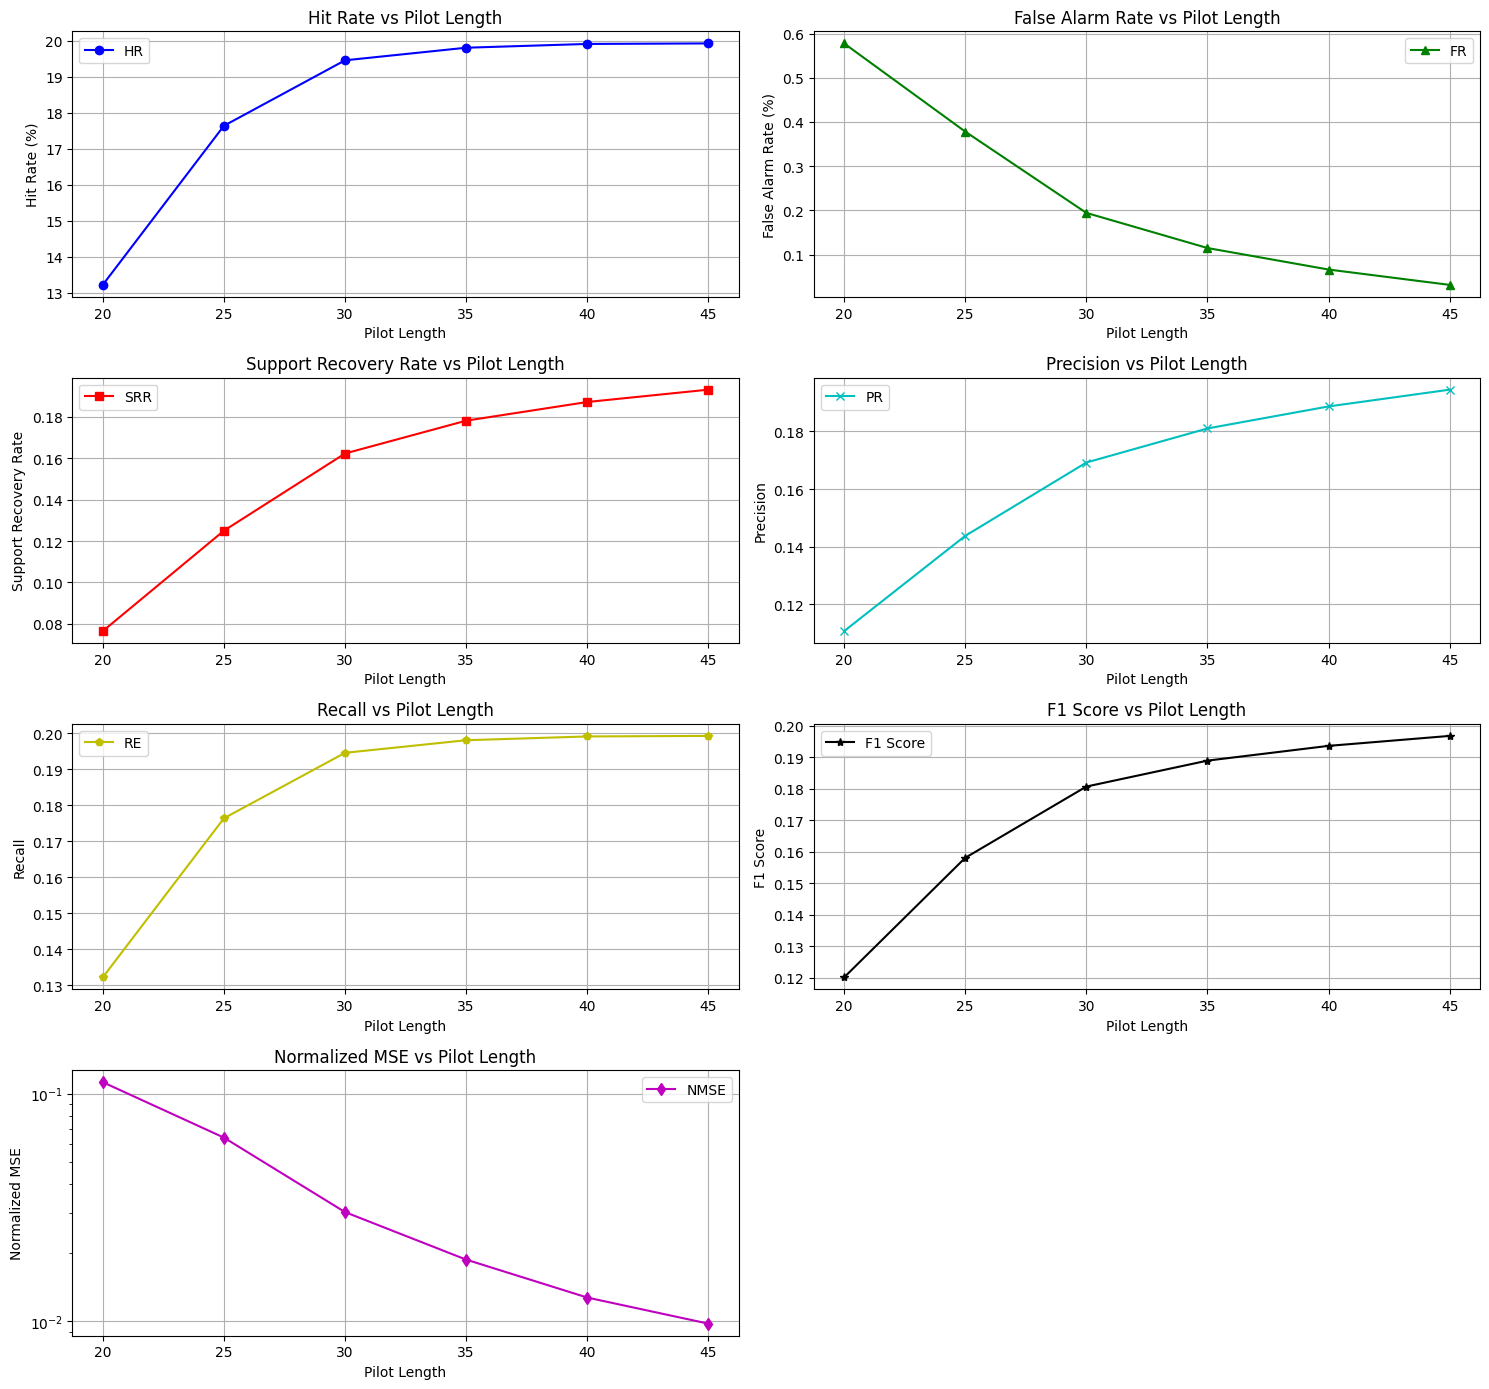

In [9]:
import matplotlib.pyplot as plt

# Define the SNR values for x-axis
pilot_length_values = pilot_length_array

# Create subplots for different performance metrics
plt.figure(figsize=(15, 14))

# Plot Hit Rate (HR)
plt.subplot(4, 2, 1)
plt.plot(pilot_length_values, avg_hr, marker='o', linestyle='-', color='b', label='HR')
plt.xlabel("Pilot Length")
plt.ylabel("Hit Rate (%)")
plt.title("Hit Rate vs Pilot Length")
plt.grid(True)
plt.legend()

# Plot False Alarm Rate (FR)
plt.subplot(4, 2, 2)
plt.plot(pilot_length_values, avg_fr, marker='^', linestyle='-', color='g', label='FR')
plt.xlabel("Pilot Length")
plt.ylabel("False Alarm Rate (%)")
plt.title("False Alarm Rate vs Pilot Length")
plt.grid(True)
plt.legend()

# Plot Support Recovery Rate (SRR)
plt.subplot(4, 2, 3)
plt.plot(pilot_length_values, avg_srr, marker='s', linestyle='-', color='r', label='SRR')
plt.xlabel("Pilot Length")
plt.ylabel("Support Recovery Rate")
plt.title("Support Recovery Rate vs Pilot Length")
plt.grid(True)
plt.legend()

# Plot Precision (PR)
plt.subplot(4, 2, 4)
plt.plot(pilot_length_values, avg_pr, marker='x', linestyle='-', color='c', label='PR')
plt.xlabel("Pilot Length")
plt.ylabel("Precision")
plt.title("Precision vs Pilot Length")
plt.grid(True)
plt.legend()

# Plot Recall (RE)
plt.subplot(4, 2, 5)
plt.plot(pilot_length_values, avg_re, marker='p', linestyle='-', color='y', label='RE')
plt.xlabel("Pilot Length")
plt.ylabel("Recall")
plt.title("Recall vs Pilot Length")
plt.grid(True)
plt.legend()

# Plot F1 Score (F1)
plt.subplot(4, 2, 6)
plt.plot(pilot_length_values, avg_f1, marker='*', linestyle='-', color='k', label='F1 Score')
plt.xlabel("Pilot Length")
plt.ylabel("F1 Score")
plt.title("F1 Score vs Pilot Length")
plt.grid(True)
plt.legend()

# Plot Normalized MSE (NMSE)
plt.subplot(4, 2, 7)
plt.plot(pilot_length_values, avg_nmse, marker='d', linestyle='-', color='m', label='NMSE')
plt.xlabel("Pilot Length")
plt.ylabel("Normalized MSE")
plt.title("Normalized MSE vs Pilot Length")
plt.yscale('log')  # Log scale for better visualization
plt.grid(True)
plt.legend()

# Adjust layout and show the plots
plt.tight_layout()
plt.show()


In [10]:
import matplotlib.pyplot as plt
import numpy as np

def plot_res_vs_ground_truth(sbl_results, Z, sample_index, snr_index, snr_value):
    """Plot sbl reconstructed signal vs ground truth (Z) for a single sample at a given SNR."""
    plt.figure(figsize=(10, 5))

    # Ground truth (Z)
    plt.plot(np.abs(Z[sample_index,:,0]), marker='s', linestyle='--', color='g', label="Ground Truth (Z)")

    # sbl Estimated Signal
    plt.plot(np.abs(sbl_results[sample_index, snr_index, :, 0]), marker='o', linestyle='-', color='b', label="sbl Estimate")

    plt.xlabel("Device Index")
    plt.ylabel("Magnitude of Signal")
    plt.title(f"sbl vs. Ground Truth (Sample {sample_index}, SNR {snr_value} dB)")
    plt.legend()
    plt.grid(True)
    plt.show()

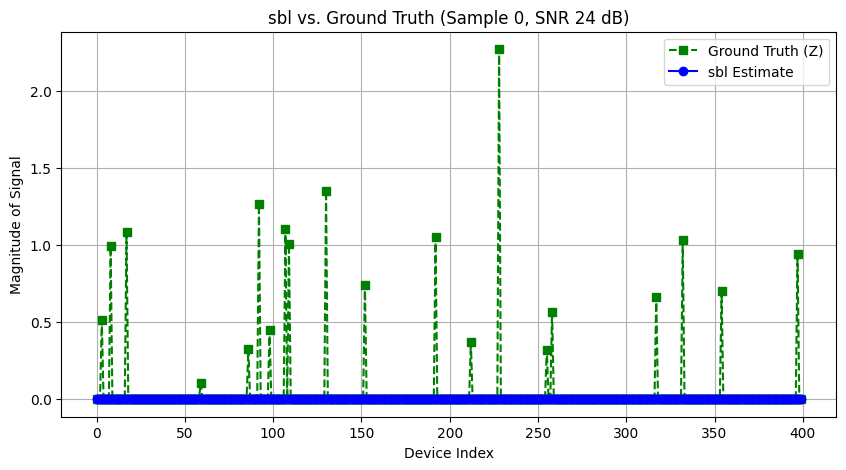

In [11]:
sample_index = 0  # Choose a specific sample
snr_index = 5  # Choose a specific SNR index
snr_value = snr_db_array[snr_index]

plot_res_vs_ground_truth(z_res, all_z, sample_index, snr_index, snr_value)

In [12]:
import matplotlib.pyplot as plt
import numpy as np

def plot_gamma_res_vs_ground_truth(gamma_res, gamma_true, sample_index, snr_index, snr_value):
    """Plot sbl estimated gamma vs ground truth gamma for a single sample at a given SNR."""
    plt.figure(figsize=(10, 5))

    device_indices = np.arange(len(gamma_true[sample_index]))  # X-axis: Device indices

    # Plot ground truth gamma (binary)
    plt.stem(device_indices, gamma_true[sample_index], linefmt='g--', markerfmt='gs', basefmt=" ", label="Ground Truth (γ)")

    # Plot sbl estimated gamma
    plt.stem(device_indices, gamma_res[sample_index, snr_index], linefmt='b-', markerfmt='bo', basefmt=" ", label="sbl Estimate (γ)")

    plt.xlabel("Device Index")
    plt.ylabel("Activity Indicator (0=Inactive, 1=Active)")
    plt.title(f"Device Activity (sbl vs. Ground Truth) - Sample {sample_index}, SNR {snr_value} dB")
    plt.legend()
    plt.grid(True)
    plt.show()


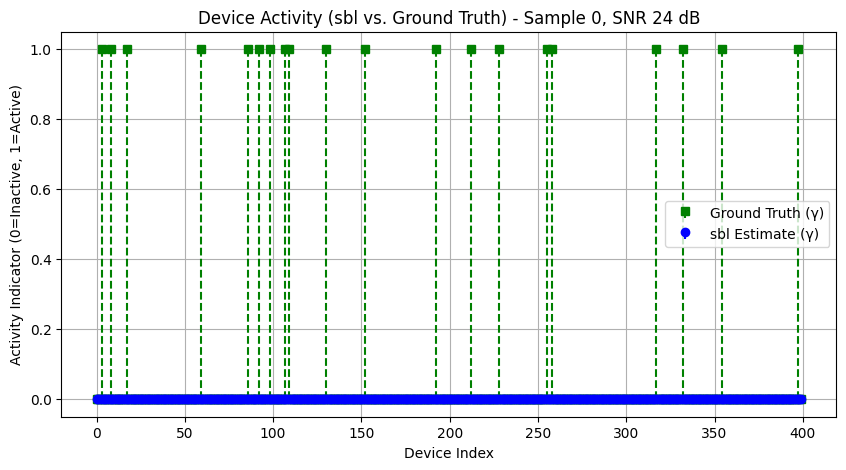

In [13]:
sample_index = 0  # Choose a specific sample
snr_index = 5  # Choose a specific SNR index
snr_value = snr_db_array[snr_index]

plot_gamma_res_vs_ground_truth(gamma_res, all_gamma, sample_index, snr_index, snr_value)